# Post-hoc analysis: Kernel SHAP
## Models: Explainable Boosting Machines - EBM (trained on LDA and categorical features)
Reference: https://interpret.ml/docs/shap.html
## Work done:
- Load pre-train models (ebm_location, ebm_side_info, ebm_extended)
- Create SHAP- Explainer
- Fit lime explainer using the pre-trained models and X_train
- Show SHAP local explanation upto 20 first items in the test data => Extract Shapley value results

In [1]:
# import caffeine
# caffeine.on(display=False)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Run this for reproduce
# Gets the current working directory
import os
cwd = os.getcwd()
print("Working directory:", cwd)
# Go up one directory from working directory
os.chdir("..")

Working directory: /home/jovyan/1_UT THESIS/CB12_MAIN/xai_recsys


In [4]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report

In [6]:
from interpret.privacy import DPExplainableBoostingClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [7]:
from interpret import show
# from interpret.blackbox import Limeflat
# from interpret.blackbox import ShapKernel

In [ ]:
import shap
shap.initjs()

# Load input data

In [9]:
# Load input: train_data_flat, test_data_flat
train_data_extended = pd.read_csv('./xai_recsys/train_data_extended.csv')
test_data_extended = pd.read_csv('./xai_recsys/test_data_extended.csv')

In [10]:
train_data_extended = train_data_extended.dropna()
test_data_extended = test_data_extended.dropna()

In [11]:
y_train = train_data_extended.label.values
y_test = test_data_extended.label.values

In [12]:
# lda jobs features
features_job = ['ReqTopic', 'DescTopic', 'TitTopic']

In [13]:
# lda & user profile features
features_user = ['DegreeType', 'CurrentlyEmployed', 'ManagedOthers', 'WorkHistoryTopic',
       'WorkHistoryLevel', 'SeniorLevel']

In [14]:
# location features
features_location = ['City', 'State', 'Country']

# Generate post-hoc explanation: Kernel SHAP

## Model: EBM location

In [15]:
X_train = train_data_extended[features_location]
X_test = test_data_extended[features_location]

In [16]:
%time
# LOAD MODEL
import gzip, pickle, pickletools
model = 'ebm_location'
filepath = "./xai_recsys/ebm_location_dropid.pikle"
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    ebm_location = p.load()

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 23.8 µs


In [17]:
%%time

# Create explainer
f = lambda x: ebm_location.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, X_test)

Using 15640 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


CPU times: user 18.3 ms, sys: 101 ms, total: 119 ms
Wall time: 300 ms


### Explain many predictions (20 first applications)
- Using interpret libary took > 2 hours for 5 first X_test
- Using shap library can shorten computing time (depends on n_samples)
Here we use a selection of 20 samples from the dataset to represent “typical” feature values, and then use 500 perterbation samples to estimate the SHAP values for a given prediction. Note that this requires 500 * 20 evaluations of the model.

- Tutorial 1: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html
- Tutorial 2:https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html

In [18]:
%%time
shap_values_ebm_location = explainer.shap_values(X_test.iloc[0:20,:], nsamples=500)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 24.9 s, sys: 9.18 s, total: 34.1 s
Wall time: 23.7 s


In [29]:
shap.initjs()

In [30]:
shap.force_plot(explainer.expected_value, shap_values_ebm_location, X_test.iloc[0:20,:])

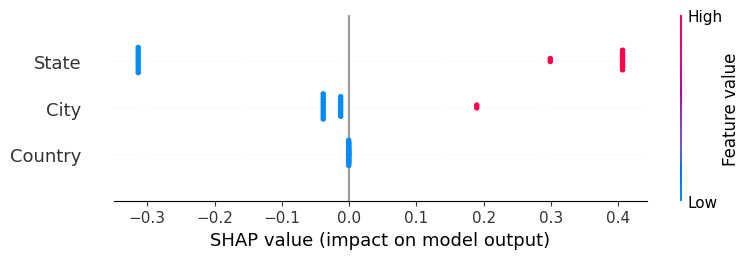

In [21]:
shap.summary_plot(shap_values_ebm_location, X_test.iloc[0:20,:])

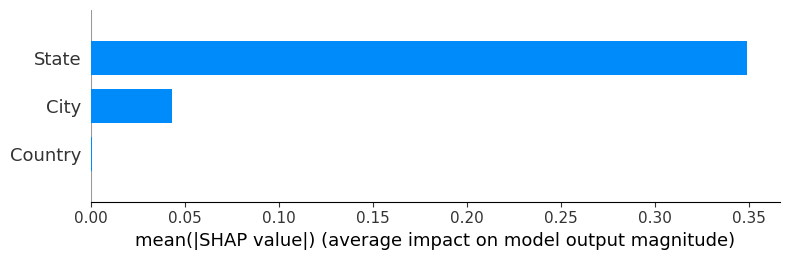

In [22]:
shap.summary_plot(shap_values_ebm_location, X_test.iloc[0:20,:], plot_type = 'bar')

In [23]:
len(shap_values_ebm_location)

20

In [24]:
shap_values_ebm_location[0]

array([-1.25648101e-02,  4.06401134e-01, -3.97668177e-04])

### Explain single case (one application)

In [31]:
%%time
# Generate explanation for one single case (X_test.iloc[0,:])
shap_values_single = explainer.shap_values(X_test.iloc[0,:], nsamples=100)
shap.force_plot(explainer.expected_value, shap_values_single, X_test.iloc[0,:])

CPU times: user 1.45 s, sys: 3.36 ms, total: 1.46 s
Wall time: 1.45 s


### Save shap_value for sample

In [26]:
shap_values_df = pd.DataFrame(shap_values_ebm_location)
shap_values_df.columns = X_train.columns

In [27]:
shap_values_df

,City,State,Country
0,-0.012565,0.406401,-0.000398
1,-0.038468,-0.313417,-0.000578
2,-0.038468,-0.313417,-0.000578
3,-0.038468,-0.313417,-0.000578
4,-0.012565,0.406401,-0.000398
5,-0.012565,0.406401,-0.000398
6,-0.012565,0.406401,-0.000398
7,-0.038468,-0.313417,-0.000578
8,-0.038468,-0.313417,-0.000578
9,-0.038468,-0.313417,-0.000578


In [32]:
shap_values_df['UserID'] = test_data_extended.iloc[0:20,:]['UserID']

In [34]:
shap_values_df['JobID'] = test_data_extended.iloc[0:20,:]['JobID']

In [35]:
shap_values_df

,City,State,Country,UserID,JobID
0,-0.012565,0.406401,-0.000398,13,821691
1,-0.038468,-0.313417,-0.000578,13,329572
2,-0.038468,-0.313417,-0.000578,514,131166
3,-0.038468,-0.313417,-0.000578,514,620304
4,-0.012565,0.406401,-0.000398,681,654542
5,-0.012565,0.406401,-0.000398,681,625758
6,-0.012565,0.406401,-0.000398,681,15081
7,-0.038468,-0.313417,-0.000578,681,291467
8,-0.038468,-0.313417,-0.000578,681,1035056
9,-0.038468,-0.313417,-0.000578,681,2083


In [36]:
shap_values_df.to_csv('./output_shap/shap_sample20_ebm_location.csv', header=True, index=False)

In [48]:
# Wrap all in a function
def get_shap_df(shap_sample_result, X_train):
    shap_values_df = pd.DataFrame(shap_sample_result)
    shap_values_df.columns = X_train.columns
    shap_values_df['UserID'] = test_data_extended.iloc[0:20,:]['UserID']
    shap_values_df['JobID'] = test_data_extended.iloc[0:20,:]['JobID']
    return shap_values_df

## Model: EBM_side_info

In [38]:
X_train_side_info = train_data_extended.drop(columns = ['label','Split','City','State','Country', 'UserID', 'JobID'], axis = 1)
X_test_side_info = test_data_extended.drop(columns = ['label','Split','City','State','Country', 'UserID', 'JobID'], axis = 1)

In [40]:
# Load a baseline model
import pickle
model = 'ebm_side_info'
# Load pre-trained model
import gzip, pickle, pickletools

filepath = "./xai_recsys/ebm_side_info_dropid.pikle"
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    ebm_side_info = p.load()

In [41]:
%%time

# Create explainer
f = lambda x: ebm_side_info.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, X_test_side_info)

Using 15640 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


CPU times: user 10.7 ms, sys: 7.02 ms, total: 17.7 ms
Wall time: 12.4 ms


In [42]:
%%time
shap_values_ebm_side_info = explainer.shap_values(X_test_side_info.iloc[0:20,:], nsamples=500)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 7min 20s, sys: 26.5 s, total: 7min 46s
Wall time: 7min 29s


In [43]:
shap.force_plot(explainer.expected_value, shap_values_ebm_side_info, X_test_side_info.iloc[0:20,:])

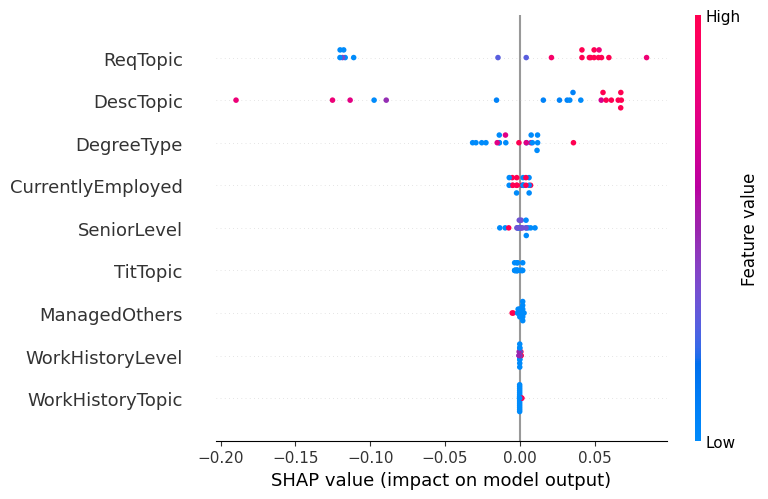

In [44]:
shap.summary_plot(shap_values_ebm_side_info, X_test_side_info.iloc[0:20,:])

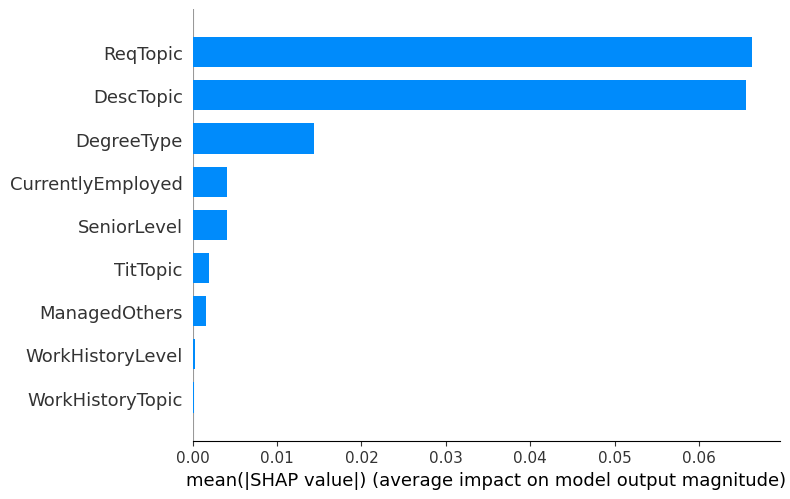

In [45]:
shap.summary_plot(shap_values_ebm_side_info, X_test_side_info.iloc[0:20,:], plot_type="bar")

In [46]:
%%time
# Explain one case
# Generate explanation for one single case (X_test.iloc[0,:])
shap_values_single = explainer.shap_values(X_test_side_info.iloc[0,:], nsamples=100)
shap.force_plot(explainer.expected_value, shap_values_single, X_test_side_info.iloc[0,:])

CPU times: user 7.15 s, sys: 79.8 ms, total: 7.23 s
Wall time: 7.21 s


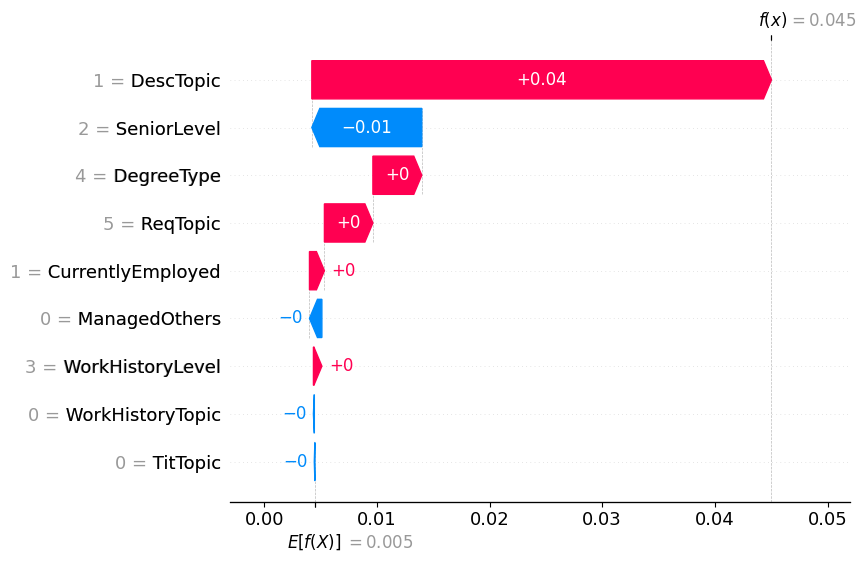

In [62]:
# Plot the SHAP waterfall for the single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values_ebm_side_info[0], 
                                     base_values=np.mean(shap_values_ebm_side_info[0]), 
                                     data=X_test_side_info.iloc[0,:]))

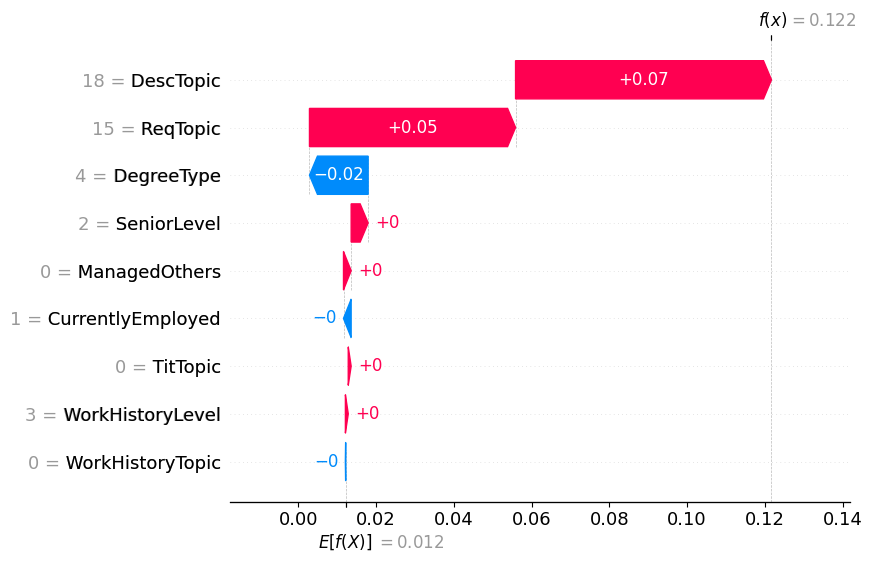

In [63]:
# Plot the SHAP waterfall for the single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values_ebm_side_info[1], 
                                     base_values=np.mean(shap_values_ebm_side_info[1]), 
                                     data=X_test_side_info.iloc[1,:]))

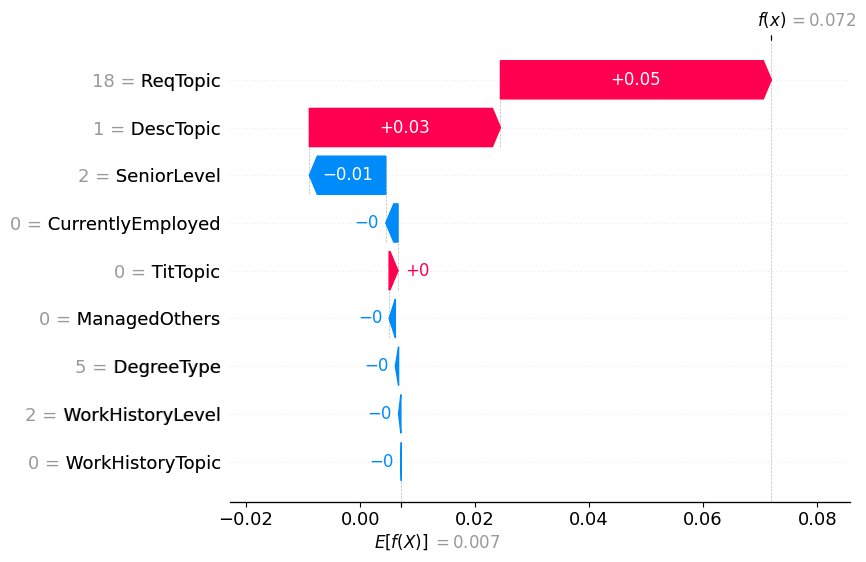

In [64]:
# Plot the SHAP waterfall for the single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values_ebm_side_info[2], 
                                     base_values=np.mean(shap_values_ebm_side_info[2]), 
                                     data=X_test_side_info.iloc[2,:]))

In [49]:
# Save shap_values 
shap_values_ebm_side_info_df = get_shap_df(shap_values_ebm_side_info, X_train_side_info)
shap_values_ebm_side_info_df.head()

,DegreeType,CurrentlyEmployed,ManagedOthers,WorkHistoryTopic,WorkHistoryLevel,SeniorLevel,ReqTopic,DescTopic,TitTopic,UserID,JobID
0,0.004338,0.001326,-0.001101,-0.000079,0.000749,-0.009758,0.004303,0.040793,-0.000050,13,821691
1,-0.015089,-0.001964,0.001971,-0.000069,0.000734,0.004366,0.053006,0.065818,0.000741,13,329572
2,-0.000572,-0.002145,-0.001089,-0.000074,-0.000400,-0.013369,0.047392,0.033431,0.001561,514,131166
3,0.035897,-0.007101,0.001962,-0.000059,-0.000370,-0.000838,0.052590,-0.125206,0.001455,514,620304
4,-0.013652,0.002327,0.001974,-0.000076,-0.000016,-0.000352,0.046502,0.067555,-0.001769,681,654542


In [50]:
shap_values_ebm_side_info_df.to_csv(f'./output_shap/shap_sample20_{model}.csv', header=True, index=False)

## Model: EBM_extended

In [51]:
X_train_extended = train_data_extended.drop(columns = ['label','Split','UserID', 'JobID'], axis = 1)
X_test_extended = test_data_extended.drop(columns = ['label','Split','UserID', 'JobID'], axis = 1)

In [52]:
# Load model
model = 'ebm_extended'
import gzip, pickle, pickletools

filepath = "./xai_recsys/ebm_extended_dropid.pikle"
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    ebm_extended = p.load()

In [53]:
%%time

# Create explainer
f = lambda x: ebm_extended.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, X_test_extended)

Using 15640 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


CPU times: user 13.5 ms, sys: 4.17 ms, total: 17.7 ms
Wall time: 12.7 ms


In [54]:
%%time
shap_values_ebm_extended = explainer.shap_values(X_test_extended.iloc[0:20,:], nsamples=500)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 7min 58s, sys: 2min 44s, total: 10min 42s
Wall time: 7min 55s


In [55]:
shap.force_plot(explainer.expected_value, shap_values_ebm_extended, X_test_extended.iloc[0:20,:])

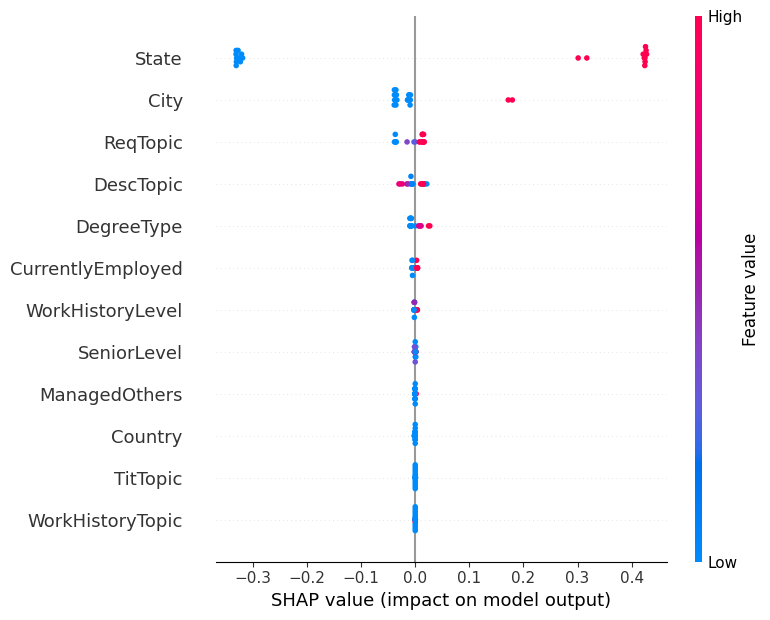

In [56]:
shap.summary_plot(shap_values_ebm_extended, X_test_extended.iloc[0:20,:])

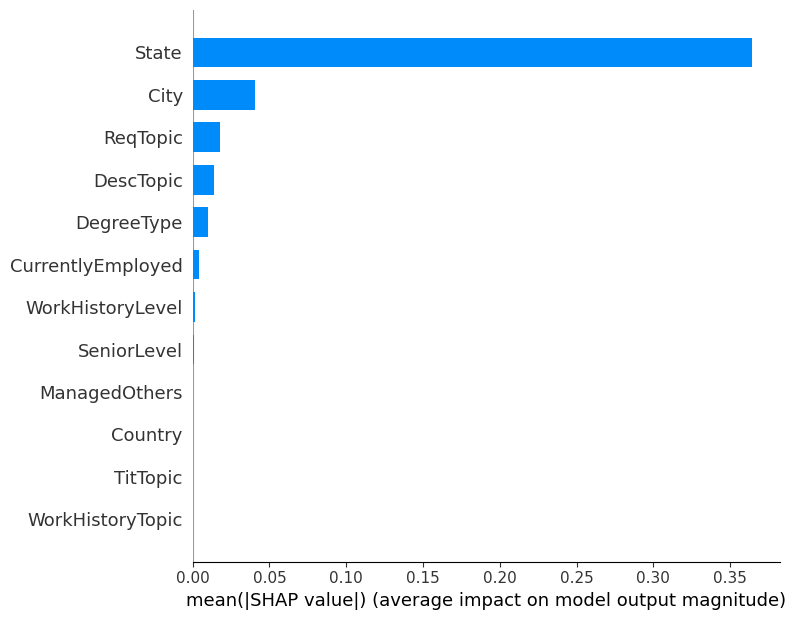

In [57]:
shap.summary_plot(shap_values_ebm_extended, X_test_extended.iloc[0:20,:], plot_type="bar")

In [58]:
%%time
# Explain one case
# Generate explanation for one single case (X_test.iloc[0,:])
shap_values_single = explainer.shap_values(X_test_extended.iloc[0,:], nsamples=100)
shap.force_plot(explainer.expected_value, shap_values_single, X_test_extended.iloc[0,:])

CPU times: user 7.81 s, sys: 53 ms, total: 7.86 s
Wall time: 7.85 s


In [59]:
# Save shap_values 
shap_values_ebm_extended_df = get_shap_df(shap_values_ebm_extended, X_train_extended)
shap_values_ebm_extended_df.head()

,City,State,Country,DegreeType,CurrentlyEmployed,ManagedOthers,WorkHistoryTopic,WorkHistoryLevel,SeniorLevel,ReqTopic,DescTopic,TitTopic,UserID,JobID
0,-0.008817,0.421192,-0.000396,0.006801,0.003024,-0.000567,0.000000,0.003197,0.000756,0.000000,0.014755,0.000176,13,821691
1,-0.038076,-0.320960,-0.001014,0.010724,0.004571,-0.000967,0.000217,0.003922,0.000682,0.015180,0.017150,0.000000,13,329572
2,-0.038901,-0.318941,-0.000702,0.026924,-0.006396,-0.000587,0.000000,-0.001560,0.001091,0.016753,0.021341,0.000000,514,131166
3,-0.037058,-0.327312,-0.002022,0.024548,-0.005853,-0.000187,0.000000,-0.001802,0.001171,0.015655,-0.030062,0.000000,514,620304
4,-0.009521,0.424200,-0.000445,-0.007140,-0.004263,-0.000607,0.000049,-0.001605,0.000721,0.013229,0.012876,0.000184,681,654542


In [60]:
shap_values_ebm_extended_df.to_csv(f'./output_shap/shap_sample20_{model}.csv', header=True, index=False)